# Bin_Classification

## Imports

In [1]:
import datetime
import os
import sys
from datetime import timedelta as timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
import sklearn.utils as sku
from scipy import signal
from scipy.stats import describe
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler

sys.path.append("/home/ugrads/c/clearloveyanzhen/CufflessBP/bioz_processing")
sys.path.append(
    "/home/ugrads/c/clearloveyanzhen/CufflessBP/BioZ_Data_Shift/"
)
import sicong_duck_path as sp
import sicong_duck_path as sdp
import sicong_util as su
import regr_bioz_REx as ru

plt.rcParams.update({"font.size": 13})
import math
import random
import warnings

import IPython.display as ipd
import scipy as sp  # for signal processing
import seaborn as sns
import shap
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import xgboost
from imblearn.over_sampling import SMOTE
from scipy import signal
from scipy.spatial import distance
from sklearn import svm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from torch import Tensor
from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings("ignore")
# os.environ["CUDA_VISIBLE_DEVICES"] = "5"
torch.cuda.set_device(5)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


## Helpers Function

### BioZ Helper Functions

In [3]:
def label_trend_converter(
    in_x,
    in_y,
    in_vals=[-1, 0],
    thre=[-2, +2],
    split_size=0.2,
    out_vals=[0, 1],
    balanced_out=True,
    resample=False,
):
    out_y = np.where(in_y == in_vals[1], out_vals[1], out_vals[0])
    out_x = in_x
    if resample:
        print("resampling")
        X_train, X_test, y_train, y_test = train_test_split(
            out_x, out_y, test_size=split_size, random_state=27
        )
    else:
        X_train, X_test = (
            out_x[: int(out_x.shape[0] * (1 - split_size)), :],
            out_x[int(out_x.shape[0] * (1 - split_size)) :, :],
        )
        y_train, y_test = (
            out_y[: int(out_x.shape[0] * (1 - split_size))],
            out_y[int(out_x.shape[0] * (1 - split_size)) :],
        )
    if balanced_out:
        print("using SMOTE")
        oversample = SMOTE()
        X_train, y_train = oversample.fit_resample(X_train, y_train)
    else:
        len_out = min(
            np.count_nonzero(out_y == out_vals[1]),
            np.count_nonzero(out_y == out_vals[0]),
        )
        print(
            np.count_nonzero(out_y == out_vals[1]),
            np.count_nonzero(out_y == out_vals[0]),
        )
        num_lab = [0, 0]
        index_list = []
        for i, e in enumerate(out_y):
            if num_lab[0] >= len_out and num_lab[1] >= len_out:
                break
            if e == 0 and num_lab[0] < len_out:
                index_list.append(i)
                num_lab[0] += 1
            if e == 1 and num_lab[1] < len_out:
                index_list.append(i)
                num_lab[1] += 1
        out_x = out_x[index_list]
        out_y = out_y[index_list]
    return X_train, X_test, y_train, y_test


def label_binary_converter(
    in_x,
    in_y,
    bp_type="sbp",
    in_vals=[140, 150],
    thre=[-2, +2],
    split_size=0.2,
    out_vals=[0, 1],
    balanced_out=True,
    resample=False,
):
    # in_x=X; in_y=y; bp_type='sbp'; in_vals=[120, 160]; thre=[-2, +2]; out_vals=[0,1]; balanced_out=True
    if len(in_y.shape) == 2:
        if bp_type == "sbp":
            in_y = in_y[:, 0]
        else:
            in_y = in_y[:, 1]
    if in_vals[0] == 0:
        out_y = in_y[
            ((in_y >= in_vals[1] - 10 + thre[0]) & (in_y <= in_vals[1] + 10 + thre[1]))
        ]
        plt.plot(out_y, "r.", alpha=0.3, label="continuous")
        plt.plot(
            np.where(
                (out_y >= in_vals[1] + thre[0]) & (out_y <= in_vals[1] + thre[1]),
                in_vals[1],
                max(in_vals[0], 110),
            ),
            "k.",
            alpha=0.2,
            label="discrete",
        )
        out_y = np.where(
            (out_y >= in_vals[1] + thre[0]) & (out_y <= in_vals[1] + thre[1]),
            out_vals[1],
            out_vals[0],
        )
        out_x = in_x[
            ((in_y >= in_vals[1] - 10 + thre[0]) & (in_y <= in_vals[1] + 10 + thre[1]))
        ]
    else:
        out_y = in_y[
            ((in_y >= in_vals[0] + thre[0]) & (in_y <= in_vals[0] + thre[1]))
            | ((in_y >= in_vals[1] + thre[0]) & (in_y <= in_vals[1] + thre[1]))
        ]
        plt.plot(out_y, "r.", alpha=0.3, label="continuous")
        plt.plot(
            np.where(
                (out_y >= in_vals[1] + thre[0]) & (out_y <= in_vals[1] + thre[1]),
                in_vals[1],
                max(in_vals[0], 110),
            ),
            "k.",
            alpha=0.2,
            label="discrete",
        )
        out_y = np.where(out_y < in_vals[1] + thre[0], 0, 1)
        out_x = in_x[
            ((in_y >= in_vals[0] + thre[0]) & (in_y <= in_vals[0] + thre[1]))
            | ((in_y >= in_vals[1] + thre[0]) & (in_y <= in_vals[1] + thre[1]))
        ]
    plt.legend()
    plt.show()
    if resample:
        print("resampling")
        X_train, X_test, y_train, y_test = train_test_split(
            out_x, out_y, test_size=split_size, random_state=36
        )
    else:
        X_train, X_test = (
            out_x[: int(out_x.shape[0] * (1 - split_size)), :],
            out_x[int(out_x.shape[0] * (1 - split_size)) :, :],
        )
        y_train, y_test = (
            out_y[: int(out_x.shape[0] * (1 - split_size))],
            out_y[int(out_x.shape[0] * (1 - split_size)) :],
        )
    if balanced_out:
        print("using SMOTE")
        oversample = SMOTE()
        X_train, y_train = oversample.fit_resample(X_train, y_train)
    else:
        len_out = min(
            np.count_nonzero(out_y == out_vals[1]),
            np.count_nonzero(out_y == out_vals[0]),
        )
        print(
            np.count_nonzero(out_y == out_vals[1]),
            np.count_nonzero(out_y == out_vals[0]),
        )
        num_lab = [0, 0]
        index_list = []
        for i, e in enumerate(out_y):
            if num_lab[0] >= len_out and num_lab[1] >= len_out:
                break
            if e == 0 and num_lab[0] < len_out:
                index_list.append(i)
                num_lab[0] += 1
            if e == 1 and num_lab[1] < len_out:
                index_list.append(i)
                num_lab[1] += 1
        X_train = X_train[index_list]
        y_train = y_train[index_list]
    return X_train, X_test, y_train, y_test

In [4]:
def Binary_REx_Runner(pname="75A", in_vals=[140, 150]):
    ru.flags = ru.parsing_args()
    ru.flags.test_index = 2
    ru.flags.n_restarts = 3
    ru.flags.print_eval_intervals = False
    ru.flags.jupyter_notebook = True
    ru.flags.pred_content = f"binary_{in_vals[0]}_{in_vals[1]}"
    ru.flags.sel_sessions = "05,06,07"
    ru.flags.pnames = pname
    ru.flags.steps = 501
    ru.flags.npy_data_path = "/home/ugrads/c/clearloveyanzhen/CufflessBP/subject_variance_analysis/batched_data/trial2trial/"
    envs, _ = ru.preprocess()
    print(f"tested on {envs[ru.flags.test_index]['fname']}")
    fitted_model = ru.fit_model(envs)
    rex_mlp = fitted_model[0]
    return rex_mlp


# def torch_cross_validator(torch_model, X_data, y_data, cv=10, scoring='f1'):
#     if scoring=='f1':
#         scoring_func=ru.calc_f1_score
#     skf=StratifiedKFold(n_splits=cv)
#     for train_index, test_index in skf.split(X_data.cpu().numpy(), y_data.cpu().numpy()):
#         X_train, X_test = X_data[train_index], X_data[test_index]
#         y_train, y_test = y_data[train_index], y_data[test_index]
#         scoring_func(torch_model(


def Binary_XGB_Runner(
    X_train,
    X_test,
    y_train,
    y_test,
    model_type="xgb",
    label_list=[120, 130],
    show_visual=True,
):
    print(f"label_list={label_list}")
    xgb = xgboost.XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",
        max_depth=6,
        use_label_encoder=False,
    )
    models_used = {"xgb": xgb}
    model_names = {"xgb": "XGBoost"}
    colors_used = {"xgb": "blue"}
    scores = {}
    for model in models_used:
        # skf=StratifiedKFold(n_splits=5)
        # for train_index, test_index in skf.split(X, y):
        scores[model] = cross_val_score(
            models_used[model], X_train, y_train, cv=10, scoring="f1"
        )
    if show_visual:
        plt.title(
            f"cross validation F1 Scores ({label_list[0]} vs. {label_list[1]} mmHg)"
        )
    for model in scores:
        if show_visual:
            plt.plot(scores[model], color=colors_used[model], label=model_names[model])
            plt.axhline(
                np.mean(scores[model]),
                color=colors_used[model],
                label=str(np.mean(scores[model]))[:5],
            )
            plt.ylim([0.5, 1])
        print(
            f"{model} with Average={np.mean(scores[model]):.3f} with STD={np.std(scores[model]):.3f}"
        )
    if show_visual:
        plt.legend()
        plt.show()
    plt.close()
    for model in models_used:
        models_used[model].fit(X_train, y_train)
        y_pred = models_used[model].predict(X_test)
        print(f"validation prediction={f1_score(y_test, y_pred):.3f}")
        if show_visual:
            plot_confusion_matrix(
                models_used[model],
                X_test,
                y_test,
                display_labels=[str(label_list[0]), str(label_list[1])],
            )
            plt.title("Confusion Matrix of BP Classification from BioZ Waveform")
            plt.show()
    return models_used, scores

### FSM Functions

In [5]:
def train_REx_model(
    X,
    y,
    pname="75A",
    norm_list=[120, 130, 140, 150, 160],
    bp_type="sbp",
    thre=[-2, 2],
    split_size=0.33,
    balanced_out=True,
    resample=True,
    show_visual=False,
):
    model_dict = {}
    for norm in norm_list:
        pair = [0, norm]
        models_used = Binary_REx_Runner(pname=pname, in_vals=pair)
        model_dict[norm] = models_used
    return model_dict


def train_XGB_model(
    X,
    y,
    norm_list=[120, 130, 140, 150, 160],
    bp_type="sbp",
    thre=[-2, 2],
    split_size=0.33,
    balanced_out=True,
    resample=True,
    show_visual=False,
):
    model_dict = {}
    for norm in norm_list:
        pair = [0, norm]
        X_train, X_test, y_train, y_test = label_binary_converter(
            in_x=X,
            in_y=y,
            in_vals=pair,
            bp_type=bp_type,
            thre=thre,
            balanced_out=balanced_out,
            resample=resample,
        )
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        models_used, scores = Binary_XGB_Runner(
            X_train, X_test, y_train, y_test, label_list=pair, show_visual=show_visual
        )
        model_dict[norm] = models_used["xgb"]
    return model_dict


def train_XGB_model_v2(
    X,
    y,
    norm_list=[-1, 1],
    thre=[-2, 2],
    split_size=0.33,
    balanced_out=True,
    resample=True,
    show_visual=False,
):
    model_dict = {}
    for norm in norm_list:
        pair = [0, norm]
        print(f"pair[{pair[0]}, {pair[1]}]")
        X_train, X_test, y_train, y_test = label_trend_converter(
            in_x=X,
            in_y=y,
            in_vals=pair,
            thre=thre,
            balanced_out=balanced_out,
            resample=resample,
        )
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        models_used, scores = Binary_XGB_Runner(
            X_train, X_test, y_train, y_test, label_list=pair, show_visual=show_visual
        )
        model_dict[norm] = models_used["xgb"]
    return model_dict


def test_XGB_model(
    X_test,
    model_dict,
    model_type="xgb",
    current_stages=[130],
    hint_freq=100,
    hop=5,
    norm_list=[120, 130, 140, 150, 160],
    split_size=0.2,
    resample=False,
    pred_thre=0.75,
):
    predicted_values = []
    cs = []
    current_stage = current_stages[0]
    for index in range(0, len(X_test), hop):
        y_preds = {}
        max = pred_thre
        for norm in model_dict:
            if abs(current_stage - norm) <= 10:
                if model_type == "xgb":
                    y_pred = model_dict[norm].predict(X_test[index : index + hop])
                    pred_proba = model_dict[norm].predict_proba(
                        X_test[index : index + hop]
                    )
                elif model_type == "pytorch":
                    with torch.no_grad():
                        pred_proba = (
                            model_dict[norm](
                                torch.from_numpy(X_test[index : index + hop])
                                .float()
                                .cuda()
                            )
                            .cpu()
                            .numpy()
                        )
                        y_pred = np.where(pred_proba > 0.0, 1, 0)
                y_preds[norm] = pred_proba[-1][-1]
        tes = current_stage
        for norm in y_preds:
            if y_preds[norm] > max:
                max = y_preds[norm]
                current_stage = norm
        if index % hint_freq == 0:
            cs.append(current_stages[index // hint_freq])
        else:
            cs.append(current_stage)
        predicted_values.append(y_preds)
    return model_dict, predicted_values, np.array(cs)


def test_XGB_model_v2(
    X_test,
    model_dict,
    model_type="xgb",
    current_stage=130,
    hop=5,
    norm_list=[120, 130, 140, 150, 160],
    split_size=0.2,
    resample=False,
):
    predicted_values = []
    cs = []
    for index in range(0, len(X_test), hop):
        y_preds = {}
        if model_type == "xgb":
            max = 0
        elif model_type == "pytorch":
            max = -1
        for norm in model_dict:
            if abs(current_stage - norm) <= 10:
                if model_type == "xgb":
                    y_pred = model_dict[norm].predict(X_test[index : index + hop])
                    pred_proba = model_dict[norm].predict_proba(
                        X_test[index : index + hop]
                    )
                elif model_type == "pytorch":
                    with torch.no_grad():
                        pred_proba = (
                            model_dict[norm](X_test[index : index + hop]).cpu().numpy()
                        )
                        y_pred = np.where(pred_proba > 0.0, 1, 0)
                y_preds[norm] = pred_proba[-1][-1]
        for norm in y_preds:
            if y_preds[norm] > max:
                max = y_preds[norm]
                current_stage = norm
        cs.append(current_stage)
        predicted_values.append(y_preds)
    return model_dict, predicted_values, np.array(cs)

### Label Helper Functions

In [6]:
def stage_converter(
    bp_val, norm_list=[120, 130, 140, 150, 160], thre=[-2, +2], current_stage=0
):
    for i, norm in enumerate(norm_list):
        if bp_val >= norm + thre[0] and bp_val <= norm + thre[1]:
            current_stage = norm
    return current_stage


def visual_stage_plot(
    bp_list, norm_list=[120, 130, 140, 150, 160], thre=[-2, +2], cut_off=111
):
    stage_list = []
    trend_list = [0]
    current_stage = bp_list[0] // 10 * 10
    for bp_val in bp_list:
        current_stage = stage_converter(
            bp_val, current_stage=current_stage, thre=thre, norm_list=norm_list
        )
        stage_list.append(current_stage)
    for i in range(1, len(stage_list)):
        if stage_list[i] > stage_list[i - 1]:
            trend_list.append(1)
        elif stage_list[i] < stage_list[i - 1]:
            trend_list.append(-1)
        else:
            trend_list.append(0)
    plt.figure(figsize=(10, 5), dpi=200)
    plt.plot(bp_list[:], "r-", label="original")
    plt.plot(stage_list[:], "k-", label="converted")
    plt.axvline(x=cut_off, color="c", label="train/test cutoff")
    plt.vlines(
        np.arange(0, len(y[:, 0]) + 1, 30), ymin=100, ymax=180, alpha=0.2, color="b"
    )
    plt.hlines(np.arange(120, 171, 10), xmin=0, xmax=len(y[:, 0]), alpha=0.2, color="b")
    plt.title("converted hypertension stage vs. original values")
    plt.ylabel("SBP (mmHg)")
    plt.legend()
    plt.xlabel("# of cardiac cycles (in temporal order)")
    plt.ylim([100, 170])
    plt.show()
    return np.array(trend_list), np.array(stage_list)


def butter_bandpass(lowcut, highcut, fs, order=5):
    return scipy.signal.butter(order, [lowcut, highcut], fs=fs, btype="band")


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = scipy.signal.lfilter(b, a, data)
    return y


def label_moving_average(arr, x=0.25):
    moving_averages = []
    moving_averages.append(arr[0])
    i = 1
    while i < len(arr):
        window_average = round((x * arr[i]) + (1 - x) * moving_averages[-1], 2)
        moving_averages.append(window_average)
        i += 1
    return moving_averages


def label_pure_average(arr, window_size=30):
    i = 0
    moving_averages = []
    while i < len(arr) - window_size + 1:
        window_average = round(np.sum(arr[i : i + window_size]) / window_size, 2)
        moving_averages.append(window_average)
        i += 1
    return np.array(moving_averages)

### Feed Data

In [7]:
X = np.load("batched_data/trial2trial/X_file 75A Morph 06 11_07_35.npy")
y = np.load("batched_data/trial2trial/y_file 75A Morph 06 11_07_35.npy")
# X = np.concatenate((X[:,2100:3000], X[:,-900:]), axis=1)
# mm = MinMaxScaler()
# X = mm.fit_transform(X)
# X, y = label_binary_converter(in_x=X, in_y=y)
X.shape, y.shape

((191, 69), (191, 2))

In [8]:
X = np.load("batched_data/session2session/X_file 75A Morph 06.npy")
y = np.load("batched_data/session2session/y_file 75A Morph 06.npy")

print(X.shape, y.shape)
# X=X[:1000]
# y=y[:1000]
mm = MinMaxScaler()
X = mm.fit_transform(X)
X.shape, y.shape

(5743, 69) (5743, 2)


((5743, 69), (5743, 2))

In [94]:
X = np.load("batched_data/X_file 75E.npy")
y = np.load("batched_data/y_file 75E.npy")
X = X.reshape(len(X), -1)
X = np.concatenate((X[:, 2100:3000], X[:, -900:]), axis=1)
mm = MinMaxScaler()
X = mm.fit_transform(X)
# X, y = label_binary_converter(in_x=X, in_y=y)
X.shape, y.shape

((13690, 1800), (13690, 2))

### Making Inter-beat 

### Visualize Data

orig=(5743,), pure_average=(5734,), downsampled=(575,)


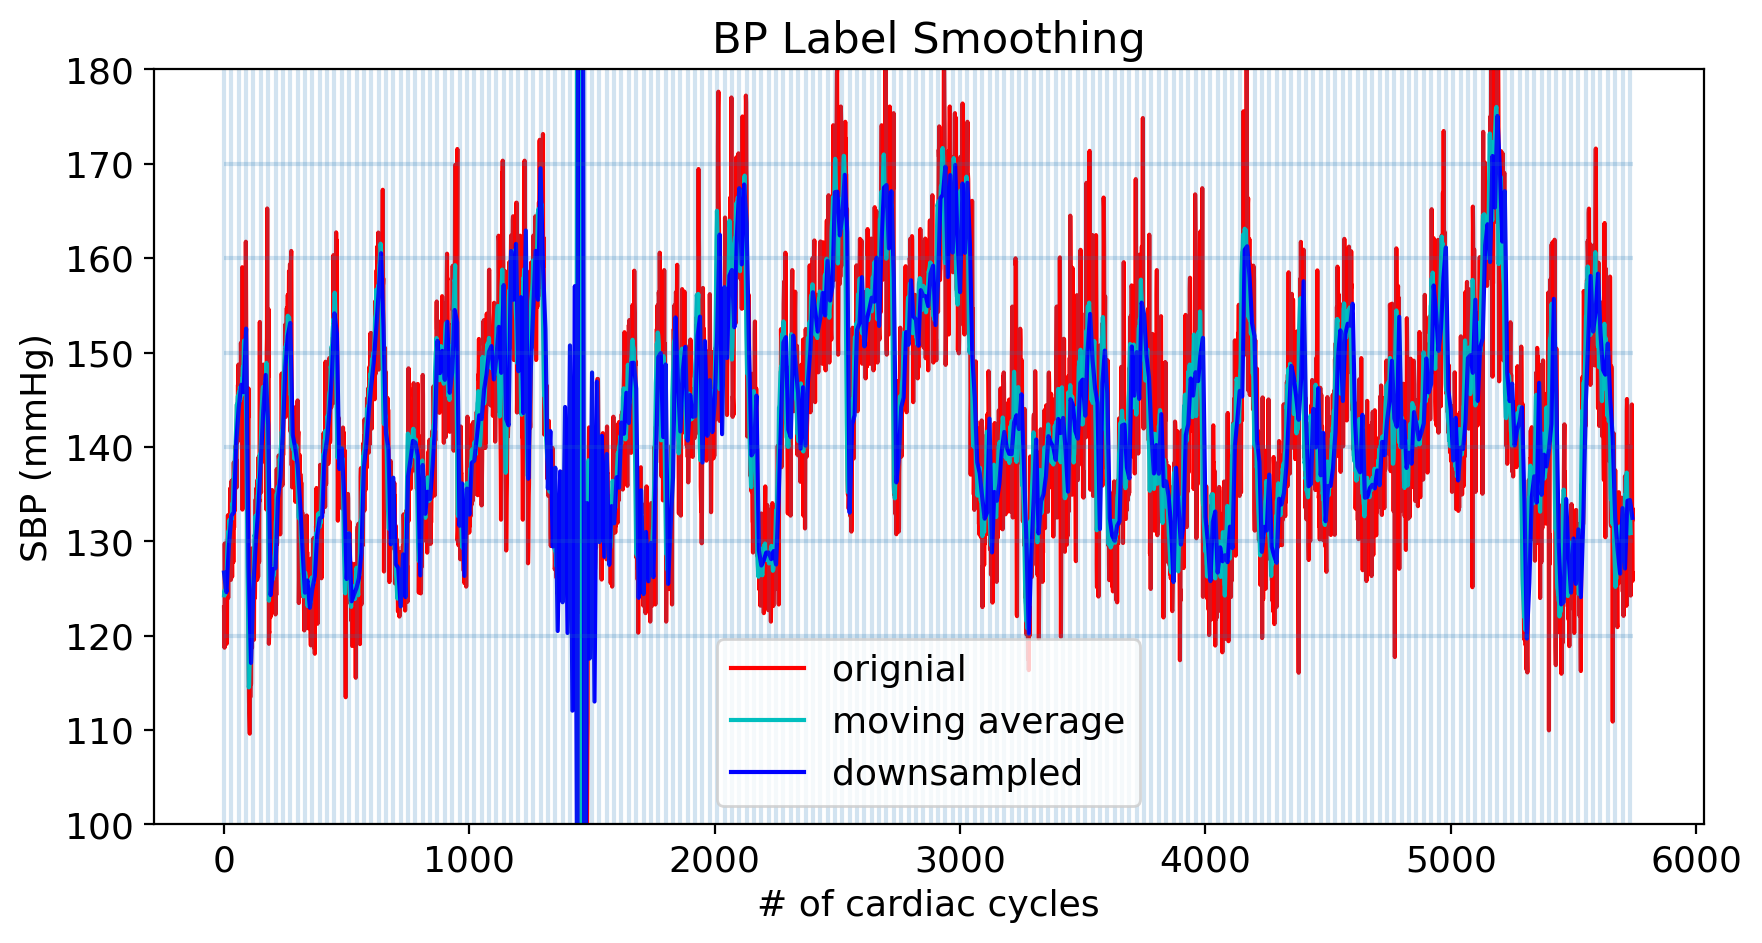

In [9]:
period = 10
plt.figure(figsize=(10, 5), dpi=200)
y_og = y[:, 0]
y_pa = label_pure_average(y[:, 0], window_size=period)
y_ds = scipy.signal.resample(y[:, 0], len(y[:, 0]) // period + 1)
plt.plot(y_og, "r", label="orignial")
plt.plot(y_pa, "c", label="moving average")
plt.plot(np.arange(0, len(y_og) + 1, period), y_ds, "b", label="downsampled")
# plt.plot(np.arange(0, len(y[:,0]), 30), y[np.arange(0, len(y[:,0]), 30),0],'k', label='other_one')
plt.vlines(np.arange(0, len(y[:, 0]) + 1, 30), ymin=100, ymax=180, alpha=0.2)
plt.hlines(np.arange(120, 171, 10), xmin=0, xmax=len(y[:, 0]), alpha=0.2)
plt.ylim([100, 180])
plt.ylabel("SBP (mmHg)")
plt.xlabel("# of cardiac cycles")
plt.legend()
plt.title("BP Label Smoothing")
print(f"orig={y_og.shape}, pure_average={y_pa.shape}, downsampled={y_ds.shape}")

Text(0.5, 0, 'feature #')

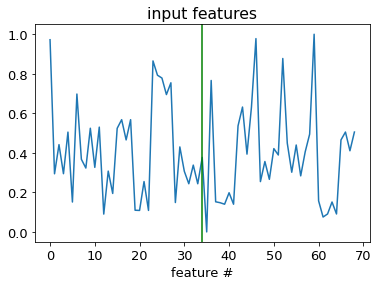

In [10]:
mm = MinMaxScaler()
te = mm.fit_transform(X[100, :].reshape(-1, 1))
plt.plot(te)
plt.axvline(x=len(te) // 2, color="g")
plt.title("input features")
plt.xlabel("feature #")

## Training Stage

### Training FSM

(13681, 1800) (13681,)
cut_off=0


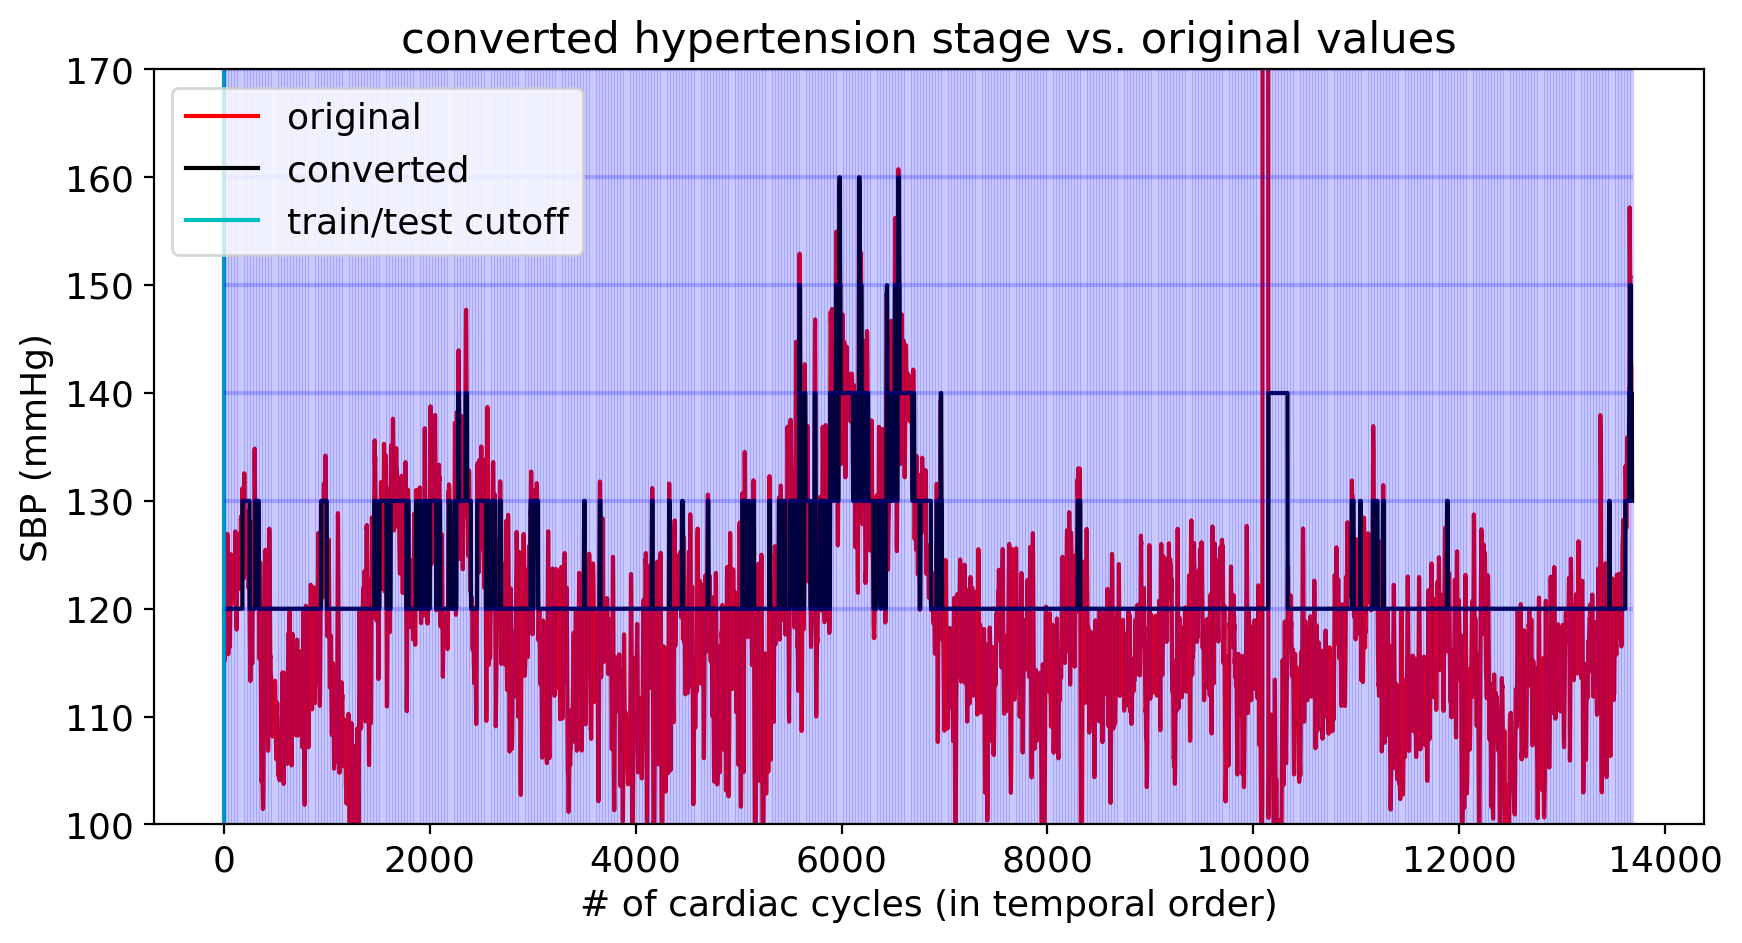

	batch_size: 4
	early_loss_mean: True
	erm_amount: 1.0
	eval_interval: 50
	f: /home/ugrads/c/clearloveyanzhen/.local/share/jupyter/runtime/kernel-e7976311-c60f-441e-8c1c-4f5078108ead.json
	feature_keyword: Morph
	gpu_core: 5
	hidden_dim: 256
	jupyter_notebook: True
	l2_regularizer_weight: 0.001
	lr: 0.001
	mse: True
	n_restarts: 3
	npy_data_path: /home/ugrads/c/clearloveyanzhen/CufflessBP/subject_variance_analysis/batched_data/trial2trial/
	penalty_anneal_iters: 100
	penalty_weight: 10000.0
	pnames: 75A
	pred_content: binary_0_120
	print_eval_intervals: False
	rex: True
	sel_sessions: 05,06,07
	steps: 501
	test_index: 2
	use_wandb: False
	wandb_project: bioz_data_shift
	wandb_tag: default_tag
There are 11 selected domains/environments
---------------------------------------------------------------------
75A Morph 05 12_06_55 torch.Size([33, 69]) torch.Size([33, 1])
75A Morph 05 12_16_25 torch.Size([18, 69]) torch.Size([18, 1])
75A Morph 05 12_32_38 torch.Size([83, 69]) torch.Size([83, 

  0%|          | 0/501 [00:00<?, ?it/s]

Restart 2


  0%|          | 0/501 [00:00<?, ?it/s]

Restart 3


  0%|          | 0/501 [00:00<?, ?it/s]

best model with accuracy=0.6987951993942261 (end of function)
	batch_size: 4
	early_loss_mean: True
	erm_amount: 1.0
	eval_interval: 50
	f: /home/ugrads/c/clearloveyanzhen/.local/share/jupyter/runtime/kernel-e7976311-c60f-441e-8c1c-4f5078108ead.json
	feature_keyword: Morph
	gpu_core: 5
	hidden_dim: 256
	jupyter_notebook: True
	l2_regularizer_weight: 0.001
	lr: 0.001
	mse: True
	n_restarts: 3
	npy_data_path: /home/ugrads/c/clearloveyanzhen/CufflessBP/subject_variance_analysis/batched_data/trial2trial/
	penalty_anneal_iters: 100
	penalty_weight: 10000.0
	pnames: 75A
	pred_content: binary_0_130
	print_eval_intervals: False
	rex: True
	sel_sessions: 05,06,07
	steps: 501
	test_index: 2
	use_wandb: False
	wandb_project: bioz_data_shift
	wandb_tag: default_tag
There are 11 selected domains/environments
---------------------------------------------------------------------
75A Morph 05 12_06_55 torch.Size([108, 69]) torch.Size([108, 1])
75A Morph 05 12_16_25 torch.Size([111, 69]) torch.Size([11

  0%|          | 0/501 [00:00<?, ?it/s]

Restart 2


  0%|          | 0/501 [00:00<?, ?it/s]

Restart 3


  0%|          | 0/501 [00:00<?, ?it/s]

best model with accuracy=0.7448275685310364 (end of function)
	batch_size: 4
	early_loss_mean: True
	erm_amount: 1.0
	eval_interval: 50
	f: /home/ugrads/c/clearloveyanzhen/.local/share/jupyter/runtime/kernel-e7976311-c60f-441e-8c1c-4f5078108ead.json
	feature_keyword: Morph
	gpu_core: 5
	hidden_dim: 256
	jupyter_notebook: True
	l2_regularizer_weight: 0.001
	lr: 0.001
	mse: True
	n_restarts: 3
	npy_data_path: /home/ugrads/c/clearloveyanzhen/CufflessBP/subject_variance_analysis/batched_data/trial2trial/
	penalty_anneal_iters: 100
	penalty_weight: 10000.0
	pnames: 75A
	pred_content: binary_0_140
	print_eval_intervals: False
	rex: True
	sel_sessions: 05,06,07
	steps: 501
	test_index: 2
	use_wandb: False
	wandb_project: bioz_data_shift
	wandb_tag: default_tag
There are 11 selected domains/environments
---------------------------------------------------------------------
75A Morph 05 12_06_55 torch.Size([172, 69]) torch.Size([172, 1])
75A Morph 05 12_16_25 torch.Size([168, 69]) torch.Size([16

  0%|          | 0/501 [00:00<?, ?it/s]

Restart 2


  0%|          | 0/501 [00:00<?, ?it/s]

Restart 3


  0%|          | 0/501 [00:00<?, ?it/s]

best model with accuracy=0.8689654469490051 (end of function)
	batch_size: 4
	early_loss_mean: True
	erm_amount: 1.0
	eval_interval: 50
	f: /home/ugrads/c/clearloveyanzhen/.local/share/jupyter/runtime/kernel-e7976311-c60f-441e-8c1c-4f5078108ead.json
	feature_keyword: Morph
	gpu_core: 5
	hidden_dim: 256
	jupyter_notebook: True
	l2_regularizer_weight: 0.001
	lr: 0.001
	mse: True
	n_restarts: 3
	npy_data_path: /home/ugrads/c/clearloveyanzhen/CufflessBP/subject_variance_analysis/batched_data/trial2trial/
	penalty_anneal_iters: 100
	penalty_weight: 10000.0
	pnames: 75A
	pred_content: binary_0_150
	print_eval_intervals: False
	rex: True
	sel_sessions: 05,06,07
	steps: 501
	test_index: 2
	use_wandb: False
	wandb_project: bioz_data_shift
	wandb_tag: default_tag
There are 11 selected domains/environments
---------------------------------------------------------------------
75A Morph 05 12_06_55 torch.Size([120, 69]) torch.Size([120, 1])
75A Morph 05 12_16_25 torch.Size([126, 69]) torch.Size([12

  0%|          | 0/501 [00:00<?, ?it/s]

Restart 2


  0%|          | 0/501 [00:00<?, ?it/s]

Restart 3


  0%|          | 0/501 [00:00<?, ?it/s]

best model with accuracy=0.7777777314186096 (end of function)
	batch_size: 4
	early_loss_mean: True
	erm_amount: 1.0
	eval_interval: 50
	f: /home/ugrads/c/clearloveyanzhen/.local/share/jupyter/runtime/kernel-e7976311-c60f-441e-8c1c-4f5078108ead.json
	feature_keyword: Morph
	gpu_core: 5
	hidden_dim: 256
	jupyter_notebook: True
	l2_regularizer_weight: 0.001
	lr: 0.001
	mse: True
	n_restarts: 3
	npy_data_path: /home/ugrads/c/clearloveyanzhen/CufflessBP/subject_variance_analysis/batched_data/trial2trial/
	penalty_anneal_iters: 100
	penalty_weight: 10000.0
	pnames: 75A
	pred_content: binary_0_160
	print_eval_intervals: False
	rex: True
	sel_sessions: 05,06,07
	steps: 501
	test_index: 2
	use_wandb: False
	wandb_project: bioz_data_shift
	wandb_tag: default_tag
There are 11 selected domains/environments
---------------------------------------------------------------------
75A Morph 05 12_06_55 torch.Size([52, 69]) torch.Size([52, 1])
75A Morph 05 12_16_25 torch.Size([53, 69]) torch.Size([53, 1

  0%|          | 0/501 [00:00<?, ?it/s]

Restart 2


  0%|          | 0/501 [00:00<?, ?it/s]

Restart 3


  0%|          | 0/501 [00:00<?, ?it/s]

best model with accuracy=0.8846153616905212 (end of function)


In [98]:
X_t = X[period - 1 :]
y_t = np.array(label_pure_average(y[:, 0], window_size=period))
# X_t=X
# y_t=y[:,0]
print(X_t.shape, y_t.shape)
norm_list = np.arange(120, 161, 10)
test_size = 0.0
cut_off = int(len(X_t) * test_size)
thre = [-1, 1]
print(f"cut_off={cut_off}")
y_trend, y_stage = visual_stage_plot(
    y_t, norm_list=norm_list, thre=thre, cut_off=cut_off
)


X_train, X_test = X_t[:cut_off], X_t[cut_off:]
y_train, y_test = y_stage[:cut_off], y_stage[cut_off:]
# X_train, X_test, y_train, y_test = train_test_split(X_t[:], y_stage[:], test_size=test_size, random_state=2)
# model_dict = train_XGB_model(X_train, y_train, norm_list=norm_list, balanced_out=True, show_visual=True, thre=thre)
model_dict = train_REx_model(
    X_train,
    y_train,
    norm_list=norm_list,
    balanced_out=True,
    show_visual=True,
    thre=thre,
)

In [99]:
hop = 1
hint_freq = 100
pred_thre = -1.0
model_dict, y_preds, cs = test_XGB_model(
    X_test[:],
    model_dict,
    model_type="pytorch",
    hop=hop,
    norm_list=norm_list,
    current_stages=y_test[::hint_freq],
    hint_freq=hint_freq,
    pred_thre=pred_thre,
)
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(
    np.arange(cut_off, cut_off + len(y), hop)[:3700],
    y[cut_off:, 0][::hop][:3700],
    "c-",
    alpha=0.75,
    label="original",
)
plt.plot(
    np.arange(cut_off, cut_off + len(y), hop)[:3700],
    y_test[cut_off:][::hop][:3700],
    "r-",
    alpha=0.75,
    label="label",
)
plt.plot(
    np.arange(cut_off, cut_off + len(y), hop)[:3700],
    cs[:3700],
    "k-",
    alpha=0.75,
    label="pred",
)
current_score = f1_score(cs, y_test[:][::hop], average="weighted")
pearson_score, _ = scipy.stats.pearsonr(cs, y_test[:][::hop])
spearman_score, _ = scipy.stats.spearmanr(cs, y_test[:][::hop])
plt.text(
    cut_off + len(cs) * 1.05 + 500, np.min(y_test) - 12, f"f1_score={current_score:.3f}"
)
plt.text(
    cut_off + len(cs) * 1.05 + 500, np.min(y_test) - 6, f"pearson_r={pearson_score:.3f}"
)
plt.text(
    cut_off + len(cs) * 1.05 + 500,
    np.min(y_test) - 0,
    f"spearman_r={spearman_score:.3f}",
)
plt.title(f"Hypertension Stage Prediction via FSM \n(every {hop} cardiac cycles)")
plt.ylabel("SBP (mmHg)")
plt.scatter(
    np.arange(cut_off, cut_off + len(y_test), hint_freq),
    y_test[::hint_freq],
    marker="^",
    linewidths=2.5,
    color="purple",
)
plt.hlines(norm_list, xmin=cut_off, xmax=cut_off + len(cs), alpha=0.2)
plt.xlabel("# of cardiac cycles")
plt.ylim([110, 180])
plt.legend()
plt.figure(figsize=(10, 5), dpi=200)
sns.heatmap(
    confusion_matrix(y_test[:][::hop], cs),
    annot=True,
    xticklabels=np.unique(cs),
    yticklabels=np.unique(cs),
    cmap="mako",
    fmt="g",
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

RuntimeError: shape '[1, 69]' is invalid for input of size 1800

In [90]:
np.arange(cut_off, cut_off + len(y), hop).shape, y_test[cut_off:-1][::hop].shape, y[
    cut_off:-2, 0
][:-1:hop].shape

((5743,), (5733,), (5740,))

In [84]:
cs.shape, y_test.shape, y_preds.shape

AttributeError: 'list' object has no attribute 'shape'

Text(0.5, 1.0, 'label distribution of clean trials')

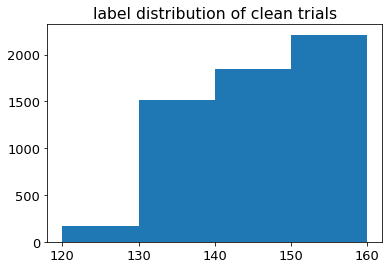

In [78]:
plt.hist(y_stage, bins=norm_list)
np.unique(cs)
plt.title("label distribution of clean trials")

In [93]:
def pretty_print(*values):
    col_width = 13

    def format_val(v):
        if not isinstance(v, str):
            v = np.array2string(v, precision=5, floatmode="fixed")
        return v.ljust(col_width)

    str_values = [format_val(v) for v in values]
    print("   ".join(str_values))


pretty_print("#cardiac_cycle", "pred_stage", "ground_truth", "raw_prediction")
for i in range(0, 100):
    pretty_print(str(i), cs[i], y_test[i], str(y_preds[i]))

#cardiac_cycle   pred_stage      ground_truth    raw_prediction
0               120.00000       120.00000       {120: -0.44177607, 130: -0.06654277}
1               140.00000       120.00000       {120: -0.44861266, 130: -0.06906603, 140: -0.0013807197}
2               150.00000       120.00000       {130: -0.06758981, 140: -0.0017921044, 150: 0.075088665}
3               150.00000       120.00000       {140: -0.0015075845, 150: 0.07032495, 160: 0.0042648544}
4               150.00000       120.00000       {140: -0.0017439821, 150: 0.07494447, 160: 0.008962614}
5               150.00000       120.00000       {140: -0.003346356, 150: 0.06260354, 160: -0.013985543}
6               150.00000       120.00000       {140: 0.0005803905, 150: 0.07659728, 160: 0.00017889822}
7               150.00000       120.00000       {140: 0.00093263906, 150: 0.07521659, 160: 0.008935744}
8               150.00000       120.00000       {140: 0.00096914504, 150: 0.08244114, 160: 0.018524323}
9              

pearson_r=0.134, spearman_r=0.082


(array([   2.,    4.,    4., 1497.,   82.,   45.,   88.,    7.,    5.,
           2.]),
 array([0.15217025, 0.23695322, 0.3217362 , 0.40651917, 0.49130215,
        0.57608512, 0.6608681 , 0.74565107, 0.83043405, 0.91521702,
        1.        ]),
 <BarContainer object of 10 artists>)

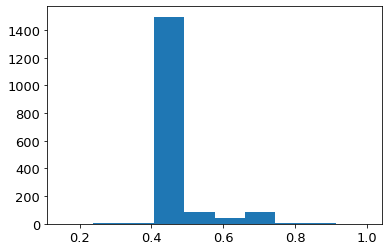

In [84]:
# _, test_x, _, test_y = label_binary_converter(in_x=X_test, in_y=y_test, in_vals=[0, 140], split_size=0.5, balanced_out=True, resample=True)
# print(f1_score(model_dict[140].predict(test_x), test_y, average='weighted'))
xt = X[(y_stage == 130)]
yt = y[(y_stage == 130)]
xt = X
yt = y
# slopes=[]
# for i in range(len(xt)):
#     b=[]
#     for j in range(0, len(xt[i]), 23):
#         b.append(xt[i][j])
#     slopes.append(scipy.stats.linregress(np.arange(len(b)), b))
# xt=np.array(slopes)[:,0]
xt = xt[np.where(xt[:, -23] != 0)]
yt = yt[np.where(xt[:, -23] != 0)]
# xt=xt[np.where(xt[:,-69] != 0)]
# yt=yt[np.where(xt[:,-69] != 0)]
# xt=xt[np.where(xt[:,-46] != 0)]
# yt=yt[np.where(xt[:,-46] != 0)]
# xt=yt[0,0]-(np.log(xt[:,-23])-np.log(xt[:,-46]))/xt[:,-69]*(-2)
xt = xt[:, -23]
# xt=abs(xt[:,-23]-xt[:,-46])/abs(xt[:,0])
yt = yt[:, 0]
pear, _ = scipy.stats.pearsonr(xt[:], yt[:])
spear, _ = scipy.stats.spearmanr(xt[:], yt[:])
print(f"pearson_r={pear:.3f}, spearman_r={spear:.3f}")
plt.hist(xt)

In [133]:
X.shape

(3913, 69)

In [35]:
# y1=cs[29:]
# y2=label_pure_average(y_test)
# y1=(y1-np.min(y1))/(np.max(y1)-np.max(y2))
# y2=(y2-np.min(y2))/(np.max(y1)-np.max(y2))
# pear, _ =scipy.stats.pearsonr(y1, y2)
# spear, _ =scipy.stats.spearmanr(y1, y2)
# print(f'pearson_r={pear:.3f}, spearman_r={spear:.3f}')
# plt.plot(cs)
# plt.show()
# plt.plot(label_pure_average(y_test))
# plt.ylim(125, 160)

In [654]:
(y_test - np.min(y_test)) / 5

array([3., 6., 5., ..., 4., 1., 5.])

### Training Trend Detection

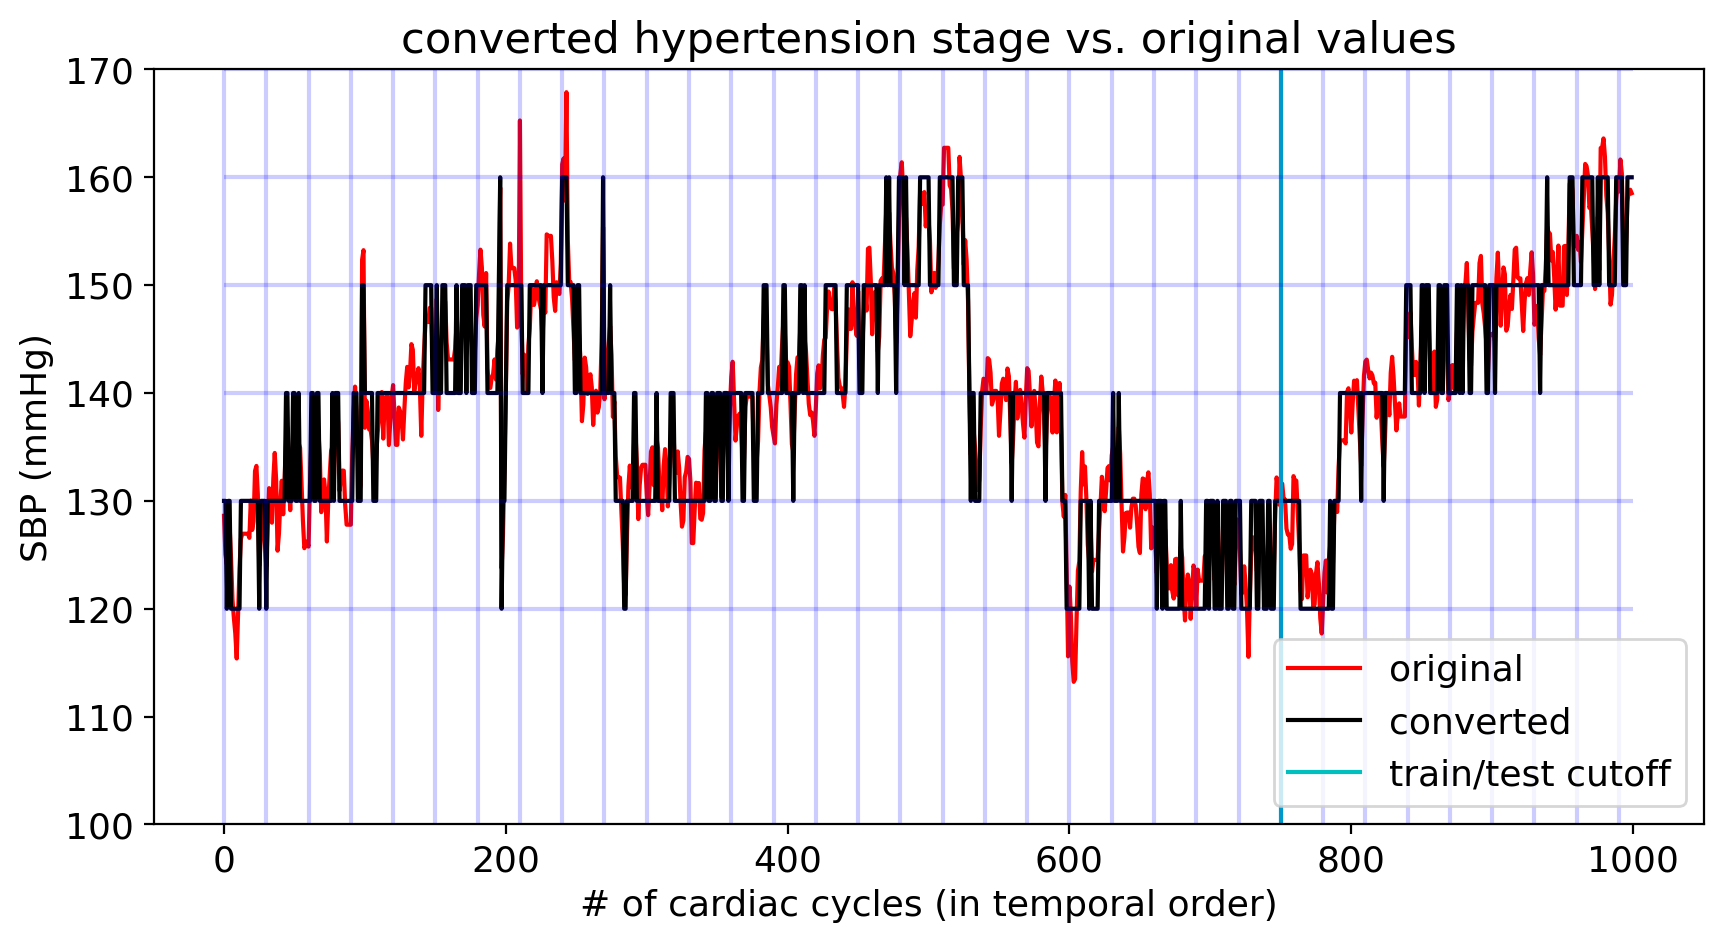

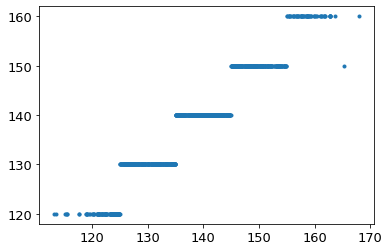

In [13]:
thre = [-5, 5]
norm_list = np.arange(120, 161, 10)
y_trend, y_stage = visual_stage_plot(
    y[:, 0], norm_list=norm_list, thre=thre, cut_off=cut_off
)
plt.plot(y[:, 0], y_stage, ".")

cut_off=1563


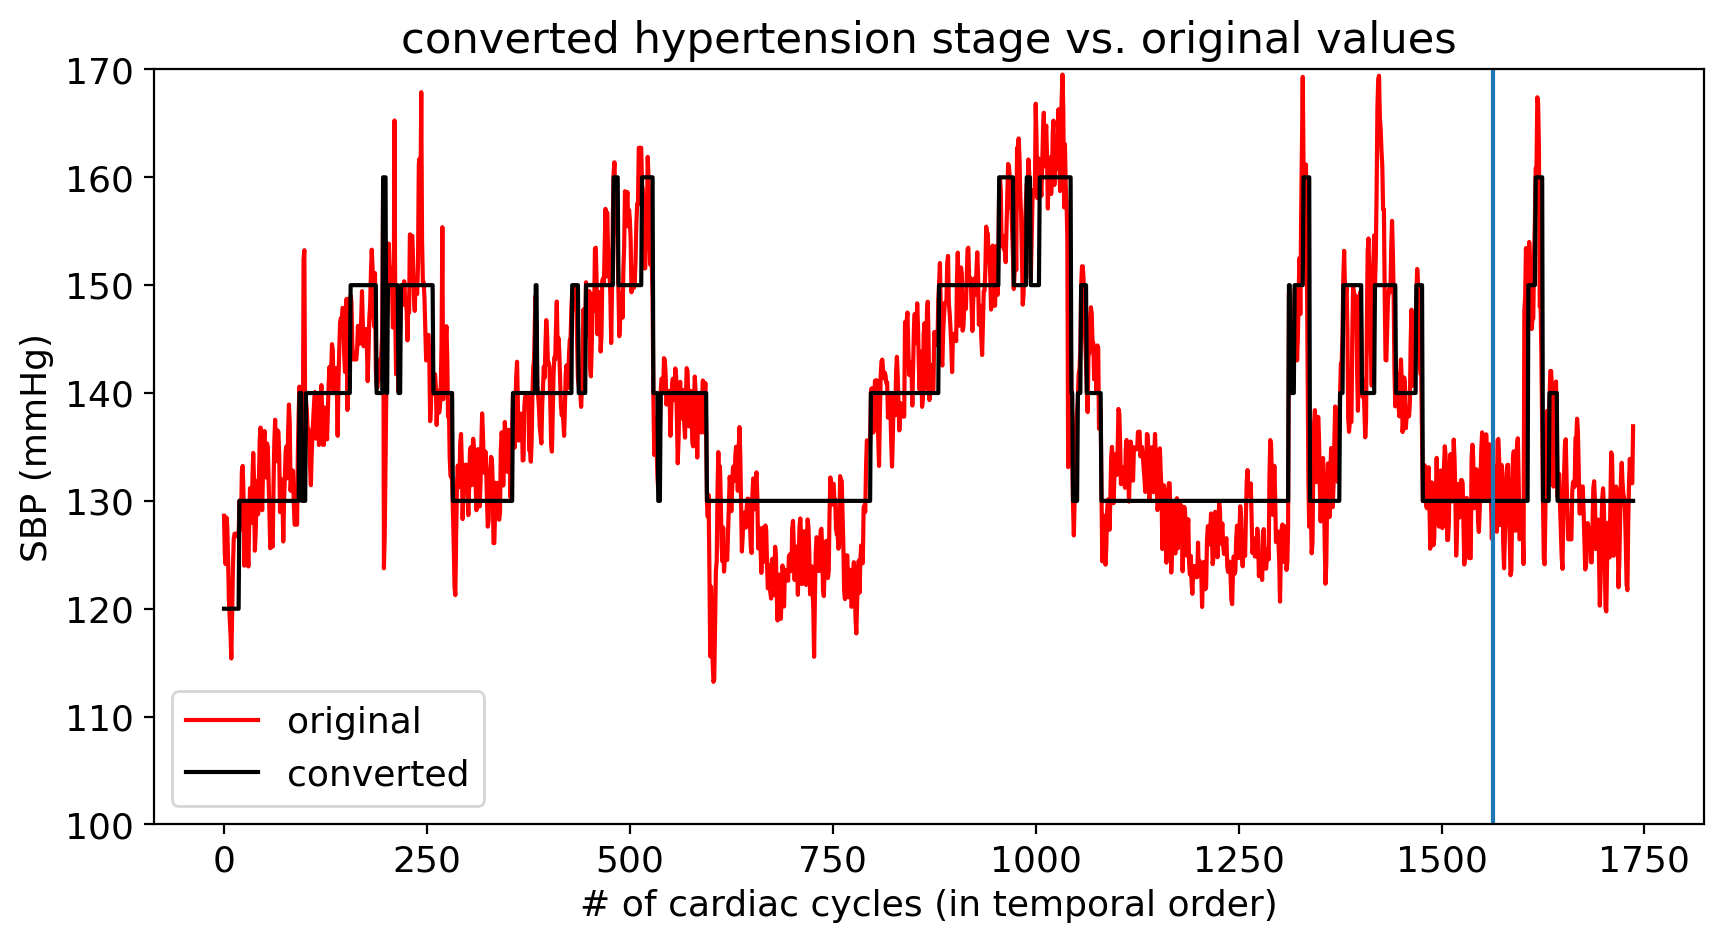

pair[0, -1]
resampling
using SMOTE


ValueError: Expected n_neighbors <= n_samples,  but n_samples = 1, n_neighbors = 6

In [110]:
thre = [-2, 2]
norm_list = np.arange(130, 161, 10)
trend_list = [-1, 1]
# X_train, X_test, y_train, y_test = label_trend_converter(in_x=X, in_y=y_trend, in_vals=[-1,0], balanced_out=False, split_size=0.2, resample=False)
# print(y_train.shape, y_test.shape)
# models_used, scores = Binary_XGB_Runner(X_train, X_test, y_train, y_test, label_list=[-1,0], show_visual=True)
test_size = 0.75
cut_off = int(len(X) * test_size)
thre = [-1, 1]
print(f"cut_off={cut_off}")
y_trend, y_stage = visual_stage_plot(
    y[:, 0], norm_list=norm_list, thre=thre, cut_off=cut_off
)
# X_train, X_test = X[:cut_off], X[cut_off:]
# y_train, y_test = y_stage[:cut_off], y_stage[cut_off:]
X_train, X_test, y_train, y_test = train_test_split(
    X[:], y_trend[:], test_size=test_size, random_state=2
)
model_dict = train_XGB_model_v2(
    X_train,
    y_train,
    norm_list=trend_list,
    balanced_out=True,
    show_visual=True,
    thre=thre,
)

In [14]:
hop = 1
model_dict, y_preds, cs = test_XGB_model_v2(
    X_test[:], model_dict, hop=hop, norm_list=trend_list, current_stage=y_test[0]
)
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(np.arange(0, len(cs)), cs, "k-", alpha=0.75, label="pred")
plt.plot(np.arange(0, len(cs)), y_test[:][::hop], "r-", alpha=0.75, label="label")
# plt.plot(np.arange(0,len(cs)), y[cut_off:,0][::hop],'c-', alpha=0.75, label='original')
current_score = f1_score(cs, y_test[:][::hop], average="weighted")
corr_score, _ = scipy.stats.pearsonr(cs, y_test[:][::hop])
plt.text(len(cs) * 1.05, np.min(y_test) - 0.1, f"f1_score={current_score:.3f}")
plt.text(len(cs) * 1.05, np.min(y_test) - 0.2, f"pearson_r={corr_score:.3f}")
plt.title(f"Hypertension Stage Prediction via FSM \n(every {hop} cardiac cycles)")
plt.ylabel("SBP (mmHg)")
plt.xlabel("# of cardiac cycles (in temporal order)")
plt.legend()  # plt.plot(np.where(y_stage[-100:] == 130, 130, 1),'r-.')
current_score = f1_score(cs, y_test[:][::hop], average="weighted")
corr_score, _ = scipy.stats.pearsonr(cs, y_test[:][::hop])
print(f"f1_score={current_score}; pearson_r={corr_score}")
plt.figure(figsize=(10, 5), dpi=200)
sns.heatmap(
    confusion_matrix(y_test, cs),
    annot=True,
    xticklabels=np.unique(cs),
    yticklabels=np.unique(cs),
    cmap="spring",
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

NameError: name 'trend_list' is not defined

In [470]:
for i, e in enumerate(y_test[:10]):
    print(i, y_preds[i], y_test[i])

0 {-1: 0.07458944, 1: 0.011113489} 1
1 {-1: 0.009396539, 1: 0.007330384} 0
2 {-1: 0.26026905, 1: 0.051027305} 0
3 {-1: 0.09167593, 1: 0.623096} 0
4 {-1: 0.001795767, 1: 0.0016424123} 0
5 {-1: 0.051558286, 1: 0.013220844} 0
6 {-1: 0.022946501, 1: 0.040718976} 0
7 {-1: 0.02776911, 1: 0.03679179} 1
8 {-1: 0.0496327, 1: 0.18590276} 0
9 {-1: 0.013203479, 1: 0.029103745} 0


In [471]:
_, test_x, _, test_y = label_trend_converter(
    in_x=X_test,
    in_y=y_test,
    in_vals=[0, 1],
    split_size=0.5,
    balanced_out=True,
    resample=True,
)
print(f1_score(model_dict[1].predict(test_x), test_y, average="weighted"))

resampling
using SMOTE
0.8960266200800533


98 150 140 shit
197 120 150 shit
269 160 150 shit
270 140 150 shit


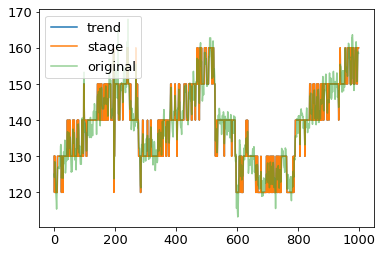

In [15]:
plt.plot(y_trend[1:] * 10 + y_stage[:-1], label="trend")
plt.plot(y_stage[1:], label="stage")
plt.plot(y[1:, 0], label="original", alpha=0.5)
plt.legend()
for i in range(1, len(y_trend)):
    if y_stage[i] != y_trend[i] * 10 + y_stage[i - 1]:
        print(i, y_stage[i], y_trend[i] * 10 + y_stage[i - 1], "shit")

In [16]:
np.count_nonzero(y_trend == -1), np.count_nonzero(y_trend == 0), np.count_nonzero(
    y_trend == 1
)

(101, 793, 106)

### Testing Binary XGBoosts

In [108]:
binary_pairs = []
for a in np.arange(130, 161, 10):
    for b in np.arange(a, a + 11, 10):
        if a != b:
            binary_pairs.append([a, b])
# for b in np.arange(120, 161, 10):
#     binary_pairs.append([0,b])
# X_in = X[np.where((y[:,0]<b+5)&(y[:,0]>b-5))]
# y_in = y[np.where((y[:,0]<b+5)&(y[:,0]>b-5))]

[140, 150]


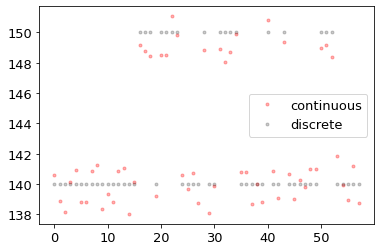

resampling
using SMOTE
(64, 69) (64,)
label_list=[140, 150]
xgb with Average=0.866 with STD=0.092


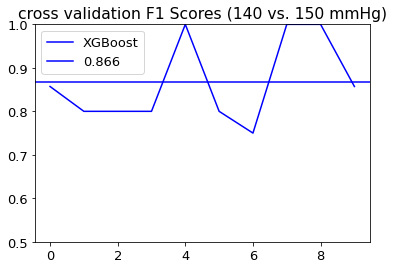

validation prediction=0.286


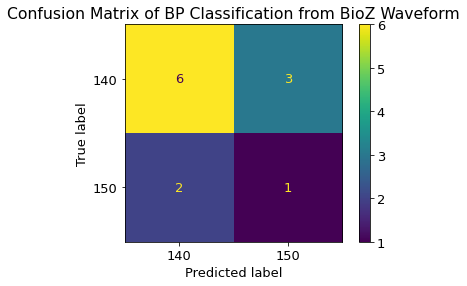

In [109]:
for pair in binary_pairs[1:2]:
    print(pair)
    b = pair[1]
    X_train, X_test, y_train, y_test = label_binary_converter(
        in_x=X, in_y=y, in_vals=pair, balanced_out=True, split_size=0.2, resample=True
    )
    print(X_train.shape, y_train.shape)
    models_used, scores = Binary_XGB_Runner(
        X_train, X_test, y_train, y_test, label_list=pair, show_visual=True
    )

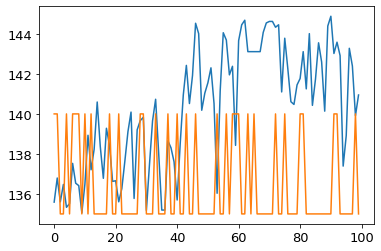

In [176]:
# asd = y[np.where((y[:,0]>b-5)&(y[:,0]<b+5))][:,0]
plt.plot(asd[:100])
plt.plot(np.where(y_train == 1, 140, 135)[:100])

In [70]:
y_train.shape, asd.shape

((2924,), (276,))

## Feature Importance Analysis

In [465]:
explainer = shap.Explainer(models_used["xgb"])
shap_test = explainer(bin_x[:100, :])
print(f"Length of shap_test: {len(shap_test)}\n")
print(f"Sample shap_test:\n{shap_test[2,:]}")

Length of shap_test: 100

Sample shap_test:
.values =
array([-0.0777137 ,  0.16994889, -0.03984185, -0.10104384,  0.02201215,
       -0.02921808, -0.20786677,  0.20056503,  0.07775002, -0.12988712,
       -0.07642762,  0.0015968 , -0.08717692, -0.04498336, -0.03883564,
       -0.0941646 ,  0.09982321,  0.11548638, -0.23611988, -0.08563559,
        0.20966834,  0.06233772, -0.12251183,  0.35445383,  0.20090757,
        0.08823585,  0.09953068,  0.04425855,  0.13518646, -0.02994797,
       -0.15671974,  0.34349203, -0.10967305,  0.566505  , -0.02579342,
        0.28783098, -0.35379755, -0.13680044, -0.08695319,  0.16622554,
        0.09433437, -0.02777039, -0.07015759, -0.3430385 , -0.03362549,
       -0.06433091,  1.3315036 ,  0.10647855,  0.09488964,  0.00927136,
        0.29722336, -0.02424682, -0.11841305,  0.15785186,  0.06354542,
        0.07481525, -0.01157993, -0.15888275,  0.23408848, -0.02750261,
        0.23776667, -0.04893617, -0.30666962, -0.00890722,  0.12920193,
        0.

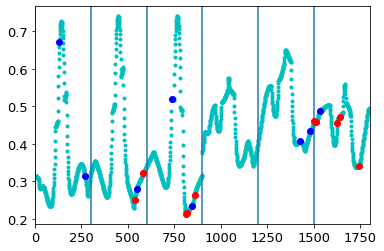

In [279]:
val_name = [
    1642,
    815,
    1514,
    859,
    537,
    1745,
    820,
    1503,
    584,
    1626,
    132,
    270,
    845,
    1482,
    737,
    1426,
    1534,
    548,
]
# val_name=[845,487,1644,851,537,1426,516,831,131,1799,859,607,1427,132,1294,161,437,73,985,1534,680,426,860]
bin_x[1, :] = bin_x[2, :]
plt.plot(signal_sample, "c.")
plt.xlim([0, 1800])
for each in np.arange(1, len(signal_sample), 300):
    plt.axvline(each)
plt.plot(val_name[:10], signal_sample[val_name[:10]], "ro")
plt.plot(val_name[10:], signal_sample[val_name[10:]], "bo")

In [261]:
bin_x[1, :].shape

(1800,)

Feature 0 = ptt
Feature 1 = ch1_ms_ibi
Feature 2 = ch1_dia_to_ms_td
Feature 3 = ch1_dia_to_sys_td
Feature 4 = ch1_dia_to_ip_td
Feature 5 = ch1_dia_to_ms_ad
Feature 6 = ch1_dia_to_sys_ad
Feature 7 = ch1_dia_to_ip_ad
Feature 8 = ch1_dia_to_ms_integrate
Feature 9 = ch1_dia_to_sys_integrate
Feature 10 = ch1_dia_to_ip_integrate
Feature 11 = ch1_dia_to_dia2_integrate
Feature 12 = ch2_ms_ibi
Feature 13 = ch2_dia_to_ms_td
Feature 14 = ch2_dia_to_sys_td
Feature 15 = ch2_dia_to_ip_td
Feature 16 = ch2_dia_to_ms_ad
Feature 17 = ch2_dia_to_sys_ad
Feature 18 = ch2_dia_to_ip_ad
Feature 19 = ch2_dia_to_ms_integrate
Feature 20 = ch2_dia_to_sys_integrate
Feature 21 = ch2_dia_to_ip_integrate
Feature 22 = ch2_dia_to_dia2_integrate
Feature 23 = ptt
Feature 24 = ch1_ms_ibi
Feature 25 = ch1_dia_to_ms_td
Feature 26 = ch1_dia_to_sys_td
Feature 27 = ch1_dia_to_ip_td
Feature 28 = ch1_dia_to_ms_ad
Feature 29 = ch1_dia_to_sys_ad
Feature 30 = ch1_dia_to_ip_ad
Feature 31 = ch1_dia_to_ms_integrate
Feature 32 = ch1_di

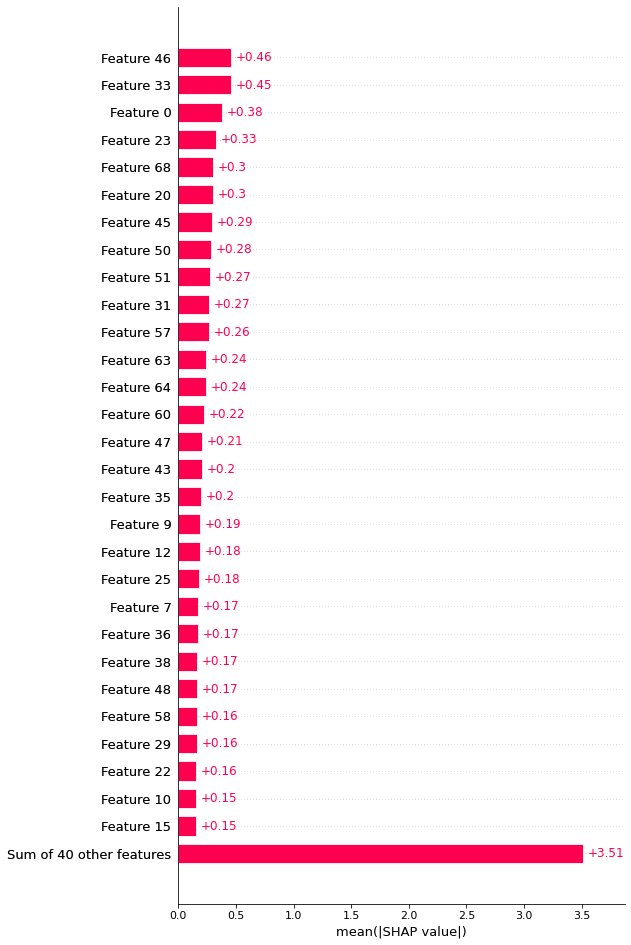

In [467]:
name_list = [
    "ptt",
    "ch1_ms_ibi",
    "ch1_dia_to_ms_td",
    "ch1_dia_to_sys_td",
    "ch1_dia_to_ip_td",
    "ch1_dia_to_ms_ad",
    "ch1_dia_to_sys_ad",
    "ch1_dia_to_ip_ad",
    "ch1_dia_to_ms_integrate",
    "ch1_dia_to_sys_integrate",
    "ch1_dia_to_ip_integrate",
    "ch1_dia_to_dia2_integrate",
    "ch2_ms_ibi",
    "ch2_dia_to_ms_td",
    "ch2_dia_to_sys_td",
    "ch2_dia_to_ip_td",
    "ch2_dia_to_ms_ad",
    "ch2_dia_to_sys_ad",
    "ch2_dia_to_ip_ad",
    "ch2_dia_to_ms_integrate",
    "ch2_dia_to_sys_integrate",
    "ch2_dia_to_ip_integrate",
    "ch2_dia_to_dia2_integrate",
]
name_list += [
    "ptt",
    "ch1_ms_ibi",
    "ch1_dia_to_ms_td",
    "ch1_dia_to_sys_td",
    "ch1_dia_to_ip_td",
    "ch1_dia_to_ms_ad",
    "ch1_dia_to_sys_ad",
    "ch1_dia_to_ip_ad",
    "ch1_dia_to_ms_integrate",
    "ch1_dia_to_sys_integrate",
    "ch1_dia_to_ip_integrate",
    "ch1_dia_to_dia2_integrate",
    "ch2_ms_ibi",
    "ch2_dia_to_ms_td",
    "ch2_dia_to_sys_td",
    "ch2_dia_to_ip_td",
    "ch2_dia_to_ms_ad",
    "ch2_dia_to_sys_ad",
    "ch2_dia_to_ip_ad",
    "ch2_dia_to_ms_integrate",
    "ch2_dia_to_sys_integrate",
    "ch2_dia_to_ip_integrate",
    "ch2_dia_to_dia2_integrate",
]
name_list += [
    "ptt",
    "ch1_ms_ibi",
    "ch1_dia_to_ms_td",
    "ch1_dia_to_sys_td",
    "ch1_dia_to_ip_td",
    "ch1_dia_to_ms_ad",
    "ch1_dia_to_sys_ad",
    "ch1_dia_to_ip_ad",
    "ch1_dia_to_ms_integrate",
    "ch1_dia_to_sys_integrate",
    "ch1_dia_to_ip_integrate",
    "ch1_dia_to_dia2_integrate",
    "ch2_ms_ibi",
    "ch2_dia_to_ms_td",
    "ch2_dia_to_sys_td",
    "ch2_dia_to_ip_td",
    "ch2_dia_to_ms_ad",
    "ch2_dia_to_sys_ad",
    "ch2_dia_to_ip_ad",
    "ch2_dia_to_ms_integrate",
    "ch2_dia_to_sys_integrate",
    "ch2_dia_to_ip_integrate",
    "ch2_dia_to_dia2_integrate",
]

pl = ""
for i, e in enumerate(name_list):
    pl += f"Feature {i} = {e}\n"
print(pl)
shap.plots.bar(shap_test, max_display=30)

In [468]:
list = [
    46,
    33,
    0,
    23,
    68,
    20,
    45,
    50,
    51,
    31,
    57,
    63,
    64,
    60,
    47,
    43,
    35,
    9,
    12,
    25,
    7,
    36,
    38,
]
for l in list:
    print(f"Feature {l} is {name_list[l]}")

Feature 46 is ptt
Feature 33 is ch1_dia_to_ip_integrate
Feature 0 is ptt
Feature 23 is ptt
Feature 68 is ch2_dia_to_dia2_integrate
Feature 20 is ch2_dia_to_sys_integrate
Feature 45 is ch2_dia_to_dia2_integrate
Feature 50 is ch1_dia_to_ip_td
Feature 51 is ch1_dia_to_ms_ad
Feature 31 is ch1_dia_to_ms_integrate
Feature 57 is ch1_dia_to_dia2_integrate
Feature 63 is ch2_dia_to_sys_ad
Feature 64 is ch2_dia_to_ip_ad
Feature 60 is ch2_dia_to_sys_td
Feature 47 is ch1_ms_ibi
Feature 43 is ch2_dia_to_sys_integrate
Feature 35 is ch2_ms_ibi
Feature 9 is ch1_dia_to_sys_integrate
Feature 12 is ch2_ms_ibi
Feature 25 is ch1_dia_to_ms_td
Feature 7 is ch1_dia_to_ip_ad
Feature 36 is ch2_dia_to_ms_td
Feature 38 is ch2_dia_to_ip_td


## ARIMA Model

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                16087
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -38868.905
Date:                Wed, 25 May 2022   AIC                          77749.810
Time:                        17:56:21   BIC                          77795.924
Sample:                             0   HQIC                         77765.058
                              - 16087                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0268      0.009     -3.047      0.002      -0.044      -0.010
ar.L2         -0.0382      0.008     -5.076      0.000      -0.053      -0.023
ar.L3         -0.0657      0.006    -10.870      0.0

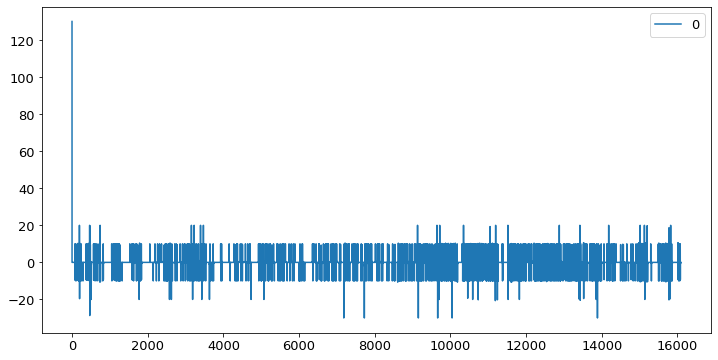

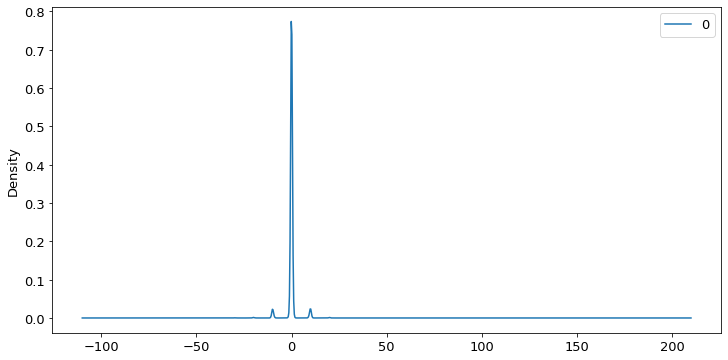

                  0
count  16087.000000
mean       0.008081
std        2.898442
min      -30.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      130.000000


In [474]:
from math import sqrt

from matplotlib import pyplot
from pandas import DataFrame, datetime, read_csv
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(y_stage[:], order=(5, 1, 0))
arima_fit = arima.fit()
print(arima_fit.summary())
residuals = DataFrame(arima_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind="kde")
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [345]:
def extract_peak(X):
    peaks = []
    for each in X:
        peaks.append(np.max(each))
    return peaks


def extract_trough(X):
    troughs = []
    for each in X:
        troughs.append(np.min(each[600:900]))
    return troughs


def extract_ptt_peak(X):
    ptts = []
    for each in X:
        ptts.append(np.max(each[600:900]) - np.max(each[-300:]))
    return ptts


def extract_ptt_trough(X):
    ptts = []
    for each in X:
        ptts.append(np.min(each[600:900]) - np.min(each[-300:]))
    return ptts


peaks = extract_peak(X)
troughs = extract_trough(X)
ptt_peaks = extract_ptt_peak(X)
ptt_troughs = extract_ptt_trough(X)

epoch=0.000000, predicted=0.745407, expected=0.746858
epoch=1.000000, predicted=0.747232, expected=0.746142


Maximum Likelihood optimization failed to converge. Check mle_retvals


epoch=4.000000, predicted=0.746262, expected=0.749320
epoch=9.000000, predicted=0.747170, expected=0.747069
epoch=24.000000, predicted=0.749132, expected=0.747537


Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals


epoch=49.000000, predicted=0.748560, expected=0.746997
Test RMSE: 0.002


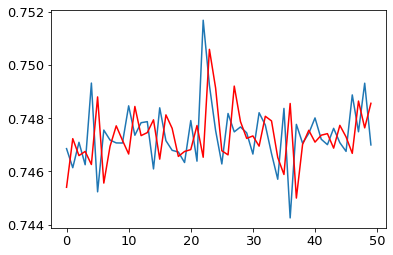

In [347]:
train, test = peaks[:1500], peaks[1500:1550]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    if len(test) % (1 + t) == 0:
        print("epoch=%f, predicted=%f, expected=%f" % (t, yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print("Test RMSE: %.3f" % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color="red")
pyplot.show()

epoch=1.000000, predicted=0.762473, expected=122.390747
epoch=11.000000, predicted=117.827372, expected=120.437622
epoch=21.000000, predicted=129.590783, expected=128.967285
epoch=31.000000, predicted=138.856966, expected=136.337280
epoch=41.000000, predicted=141.587278, expected=142.929077
epoch=51.000000, predicted=139.360927, expected=139.999390
epoch=61.000000, predicted=143.487313, expected=141.555786
epoch=71.000000, predicted=146.659943, expected=145.156860
epoch=81.000000, predicted=142.648854, expected=146.041870
epoch=91.000000, predicted=143.804378, expected=138.717651
epoch=101.000000, predicted=139.316411, expected=140.243530
epoch=111.000000, predicted=144.687719, expected=148.681641
epoch=121.000000, predicted=148.312939, expected=148.361206
epoch=131.000000, predicted=145.410563, expected=145.401001
epoch=141.000000, predicted=150.712110, expected=145.782471
Test RMSE: 2.578


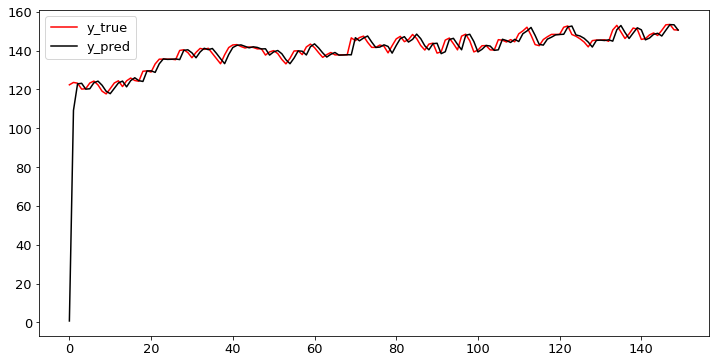

In [484]:
train, test = X_test[:1500, -23], y[1500:1650, 0]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    if t % (len(test) // 15) == 0:
        print("epoch=%f, predicted=%f, expected=%f" % (t + 1, yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test[10:], predictions[10:]))
print("Test RMSE: %.3f" % rmse)
# plot forecasts against actual outcomes
plt.plot(test, "r", label="y_true")
plt.plot(predictions, "k", label="y_pred")
plt.legend()
plt.show()

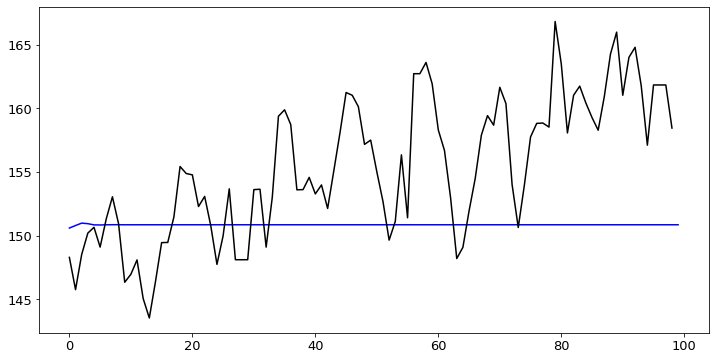

In [489]:
plt.plot(model_fit.forecast(100, exog=X_test[:, -23]), "b")
plt.plot(y[1651:1750, 0], "k")

epoch=0.000000, predicted=0.192203, expected=73.745728
epoch=1.000000, predicted=236.240514, expected=72.494507
epoch=2.000000, predicted=32.393916, expected=73.364258
epoch=4.000000, predicted=50.996174, expected=70.556641
epoch=5.000000, predicted=74.954189, expected=69.061279
epoch=9.000000, predicted=78.004104, expected=80.032349
epoch=14.000000, predicted=84.305598, expected=83.816528
epoch=24.000000, predicted=79.577190, expected=79.589844
epoch=29.000000, predicted=81.953664, expected=83.160400
epoch=49.000000, predicted=86.222574, expected=83.648682
epoch=74.000000, predicted=79.367465, expected=77.789307
epoch=149.000000, predicted=83.289862, expected=86.090088
Test RMSE: 1.727


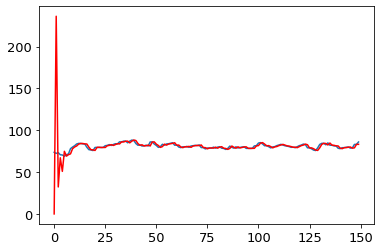

In [441]:
train, test = troughs[:1400], y[1400:1550, 1]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    if len(test) % (t + 1) == 0:
        print("epoch=%f, predicted=%f, expected=%f" % (t, yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test[5:], predictions[5:]))
print("Test RMSE: %.3f" % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color="red")
pyplot.show()

In [438]:
rmse = sqrt(mean_squared_error(test[10:], predictions[10:]))
rmse

1.6456898232073216

201 250
rmse=56.27507065432145


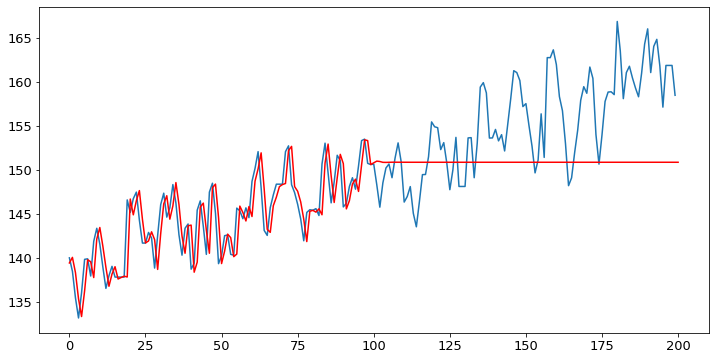

In [482]:
output = model_fit.predict(1550, 1750, dynamic=False)
print(len(output), len(y[1500:1750, 0]))
pyplot.plot(y[1550:1750, 0])
pyplot.plot(output, color="red")
print(f"rmse={sqrt(mean_squared_error(y[1510:1550,1], output[10:50]))}")

In [443]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1549
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3218.128
Date:                Wed, 18 May 2022   AIC                           6448.256
Time:                        16:25:24   BIC                           6480.324
Sample:                             0   HQIC                          6460.183
                               - 1549                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0079      0.065     -0.122      0.903      -0.135       0.119
ar.L2          0.0158      0.099      0.160      0.873      -0.178       0.209
ar.L3         -0.0358      0.119     -0.301      0.7

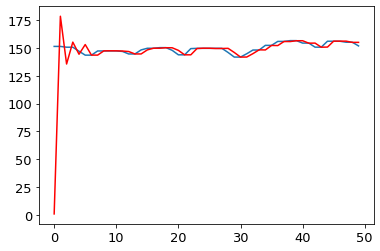

In [361]:
pyplot.plot(test)
pyplot.plot(predictions, color="red")
pyplot.show()

In [375]:
mbp = get_mbp(sbp, dbp)

In [380]:
mbp

[0.5667780602808613,
 155.40948761513036,
 116.37441745206733,
 135.4518615843028,
 125.17564515809983,
 132.77373298311036,
 125.71733389930966,
 125.67609117219591,
 128.2879948061347,
 128.29155382558295,
 128.97300166337575,
 128.84234507456995,
 128.5430094743939,
 127.76151424117059,
 127.77943296685783,
 129.8359690926431,
 131.44400185490323,
 131.4473824449616,
 132.19828283604497,
 132.1372417900634,
 130.01796243554148,
 126.68167351237035,
 126.70789054035782,
 129.94779481797988,
 130.17552433238262,
 130.12727576112067,
 129.998158995816,
 129.97625006529796,
 130.07242938412392,
 127.18002595476257,
 123.86556816233148,
 123.87803345275178,
 127.08299387553218,
 128.5448443854751,
 128.49348380047056,
 132.85912323948193,
 132.81126742099147,
 135.2469154885358,
 135.18079431970503,
 136.8449934552631,
 136.81914067285544,
 134.47917644048337,
 134.5278425042675,
 131.88654309892374,
 131.96646178952577,
 134.70272763854027,
 134.72277244681723,
 134.7123256908038,
 134.

In [379]:
def get_mbp(sbp, dbp):
    mbp = []
    for i, e in enumerate(sbp):
        mbp.append((sbp[i] + sbp[i] + dbp[i]) / 3)
        print(sbp[i], dbp[i], mbp[i])
    return mbp

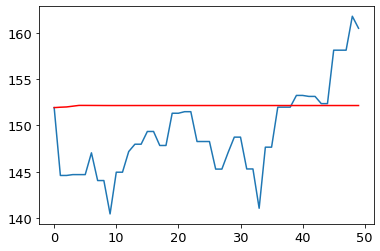

In [364]:
model = ARIMA(history, order=(5, 1, 0))
model_fit = model.fit()
output = model_fit.forecast(50)
pyplot.plot(y[2550:2600, 0])
pyplot.plot(output, color="red")

## Play Ground

In [ ]:
ru.flags = ru.parsing_args()
ru.flags.test_index = 2
ru.flags.n_restarts = 3
ru.flags.print_eval_intervals = False
ru.flags.jupyter_notebook = True
ru.flags.pred_content = f"binary_130_140"
ru.flags.sel_sessions = "05,06,07"
ru.flags.pnames = "75A"
ru.flags.steps = 501
ru.flags.npy_data_path = "/home/ugrads/c/clearloveyanzhen/CufflessBP/subject_variance_analysis/batched_data/trial2trial/"
envs, _ = ru.preprocess()
print(f"tested on {envs[ru.flags.test_index]['fname']}")
# fitted_model = ru.fit_model(envs)
# rex_mlp = fitted_model[0]

In [7]:
envs

AttributeError: 'list' object has no attribute 'keys'

In [237]:
X = np.load("batched_data/X_file 75A Morph.npy")
y = np.load("batched_data/y_file 75A Morph.npy")
X.shape, y.shape

((5743, 69), (5743, 2))

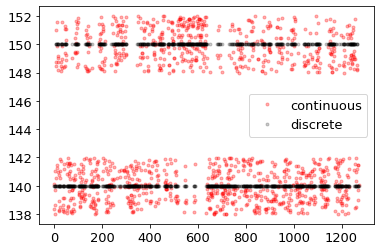

using SMOTE


In [238]:
X_train, X_test, y_train, y_test = label_binary_converter(X, y, in_vals=[140, 150])
X_train, X_test = (
    torch.from_numpy(X_train).float().cuda(),
    torch.from_numpy(X_test).float().cuda(),
)
y_train, y_test = (
    torch.from_numpy(y_train).float().cuda(),
    torch.from_numpy(y_test).float().cuda(),
)

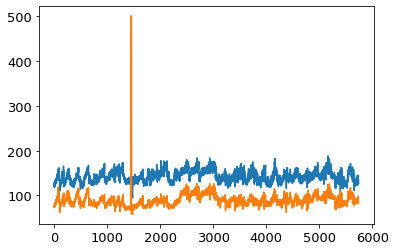

In [239]:
plt.plot(y)

In [247]:
with torch.no_grad():
    logits = rex_mlp(X_test)
    y_pred = preds = (logits > 0.0).int()

In [248]:
ru.calc_f1_score(y_pred, y_test)

tensor(0.4353, device='cuda:0')

<AxesSubplot:>

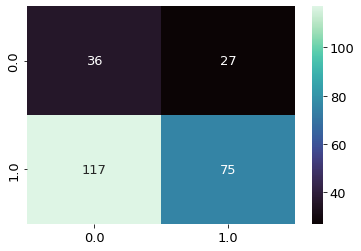

In [249]:
sns.heatmap(
    confusion_matrix(y_pred.cpu().numpy(), y_test.cpu().numpy()),
    annot=True,
    xticklabels=np.unique(y_test.cpu().numpy()),
    yticklabels=np.unique(y_test.cpu().numpy()),
    cmap="mako",
    fmt="g",
)

In [251]:
with torch.no_grad():
    logits = rex_mlp(X_test).cpu().numpy()

In [254]:
preds = np.where(logits > 0.0, 1, 0)